<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\miche\AppData\Local\Temp\ipykernel_24952\671167624.py:35: SyntaxWarning: invalid escape sequence '\s'
  .str.split(',\s*')


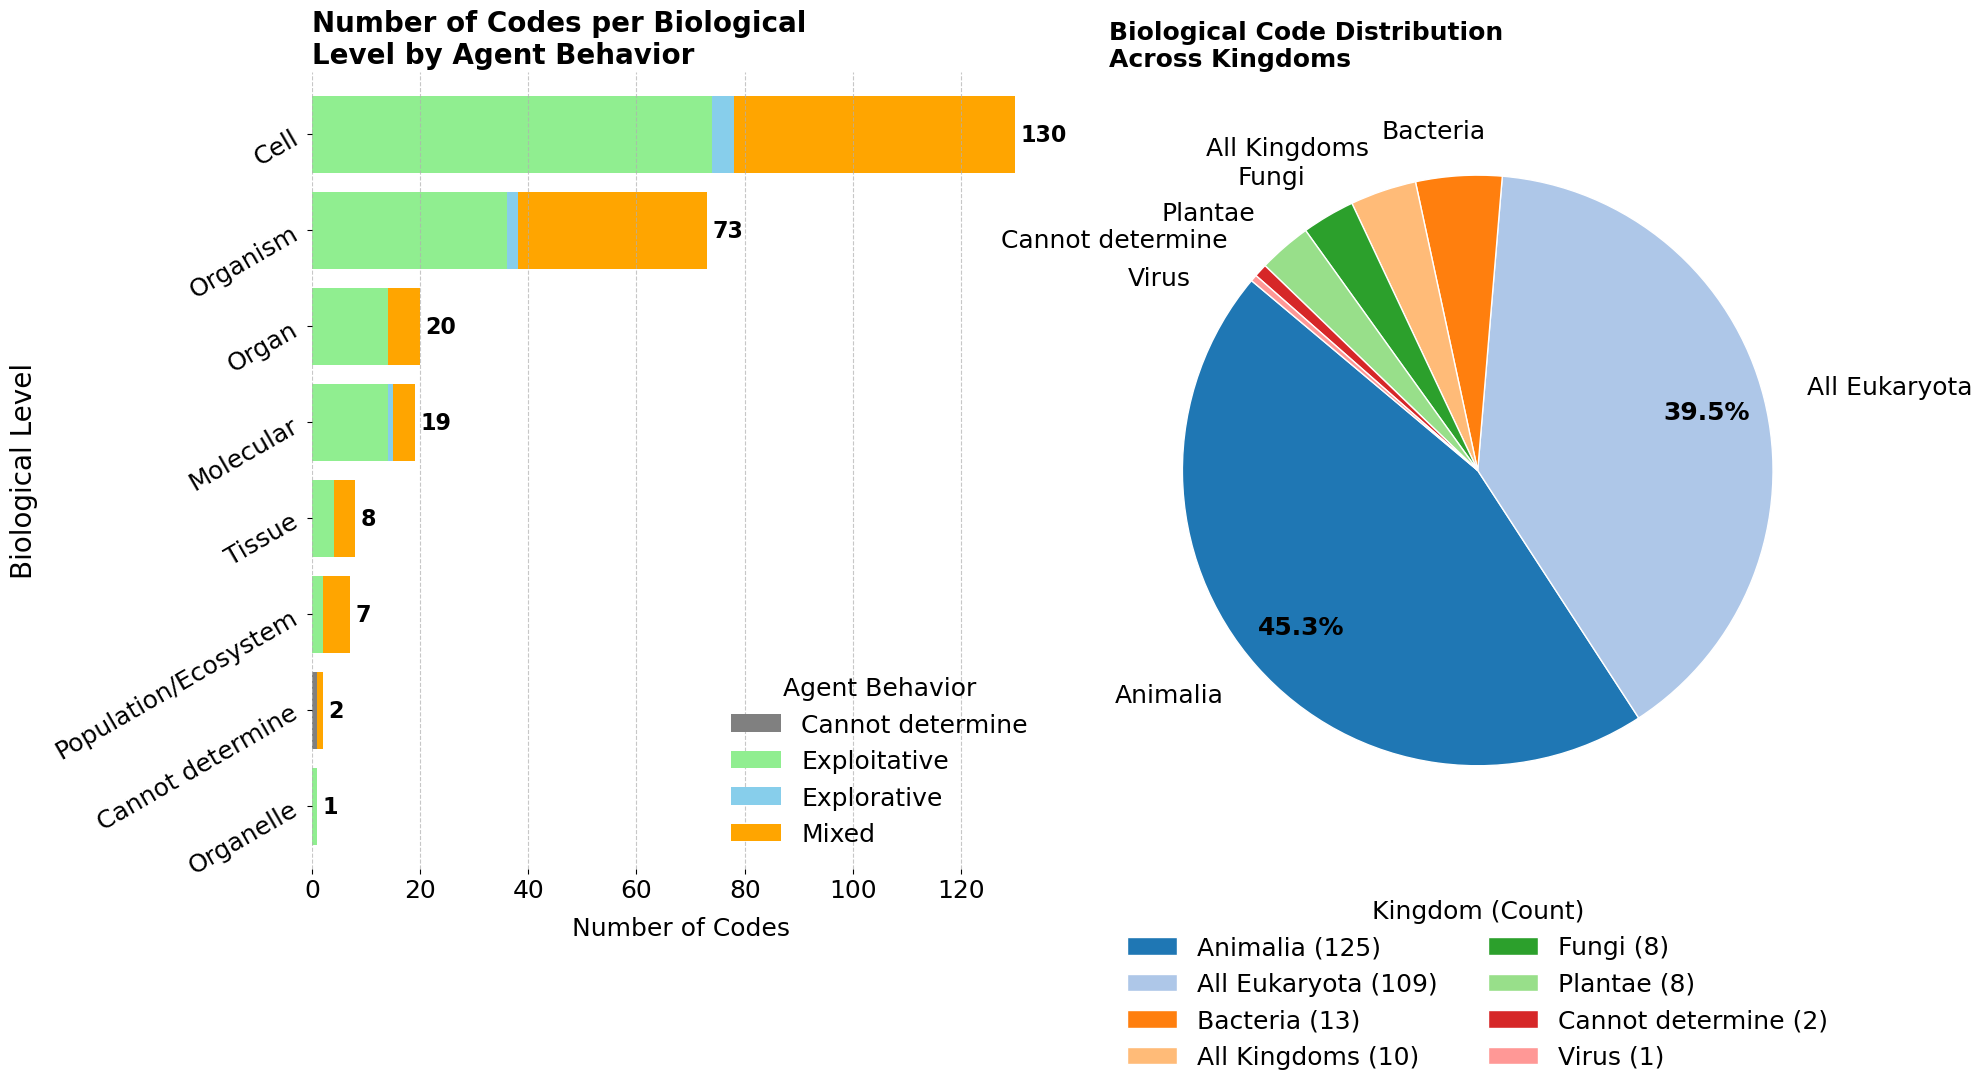

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the Data ---
file_path = 'Codes_1-261.xlsx'  # Ensure this file exists in your working directory
df = pd.read_excel(file_path, sheet_name='in', skiprows=1)

# --- Bar Chart Data Preparation ---
def disentangled_biological_level(level):
    if not isinstance(level, str):
        return level
    if level == 'Organelle':
        return 'Organelle'
    # Group all 'Organ' (but not 'Organism') together
    if 'organ' in level.lower() and 'organism' not in level.lower():
        return 'Organ'
    if level == 'Cell/Tissue':
        return 'Tissue'
    return level

df['Lumped Biological Level'] = df['Biological Level Label'].apply(disentangled_biological_level)
bio_agent_counts = df.groupby(['Lumped Biological Level', 'Agent Behavior Type Label']).size().unstack(fill_value=0)
bio_agent_counts['Total'] = bio_agent_counts.sum(axis=1)
bio_agent_counts_sorted = bio_agent_counts.sort_values('Total', ascending=False).drop(columns='Total')

# Define colors for agent behavior
bar_colors = {'Exploitative': 'lightgreen', 'Mixed': 'orange', 'Explorative': 'skyblue', 'Cannot determine': 'gray'}

# --- Pie Chart Data Preparation ---
kingdom_series = df['Kingdom(s) Involved']
normalized_kingdoms = (
    kingdom_series.str.replace(r'Animalia.*', 'Animalia', regex=True)
                  .str.replace(r'All.*', 'All Kingdoms', regex=True)
                  .str.replace(r'.*Ecosystem.*', 'All Kingdoms', regex=True)
                  .str.split(',\s*')
)
exploded_kingdoms = normalized_kingdoms.explode()
kingdom_counts = exploded_kingdoms.value_counts().sort_values(ascending=False)
total = kingdom_counts.sum()
distribution_df = pd.DataFrame({
    'Kingdom': kingdom_counts.index,
    'Count': kingdom_counts.values,
    'Percentage': (kingdom_counts.values / total * 100).round(1)
})

# --- MODIFICATION: Replace 'Eukaryota' with 'All Eukaryota' ---
distribution_df['Kingdom'] = distribution_df['Kingdom'].replace('Eukaryota', 'All Eukaryota')
distribution_df['Kingdom'] = distribution_df['Kingdom'].replace('Virus (not a kingdom)', 'Virus')

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# --- Left Panel: Horizontal Stacked Bar Chart ---
bio_agent_counts_sorted.plot(
    kind='barh',
    stacked=True,
    color=[bar_colors.get(col, 'gray') for col in bio_agent_counts_sorted.columns],
    ax=ax1,
    width=0.8  # Make horizontal bars thicker
)
ax1.invert_yaxis()
for i, (index, row) in enumerate(bio_agent_counts_sorted.iterrows()):
    total_row = row.sum()
    ax1.text(total_row + 1, i, str(total_row), va='center', fontweight='bold', fontsize=16)  # Increased font size

# Wrapped left panel headline with line break
left_title = 'Number of Codes per Biological\nLevel by Agent Behavior'
ax1.set_title(left_title, fontsize=20, fontweight='bold', loc='left')  # Increased font size

ax1.set_xlabel('Number of Codes', fontsize=18, labelpad=10)  # Increased font size
ax1.set_ylabel('Biological Level', fontsize=20, labelpad=10)  # Increased font size for biological levels label
ax1.tick_params(axis='both', labelsize=18)  # Increased font size for tick labels

# --- MODIFICATION: Slant panel 1 labels at 30 degrees ---
ax1.tick_params(axis='y', labelsize=18, rotation=30)  # Increased font size and added 30-degree rotation

for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.legend(title='Agent Behavior', fontsize=18, title_fontsize=18, loc='lower right', frameon=False)  # Increased font sizes

# --- Right Panel: Pie Chart (BIGGER SIZE) ---
colors_pie = plt.cm.tab20.colors

# --- MODIFICATION: Make pie chart bigger and position it at the top ---
ax2.set_position([0.55, 0.3, 0.4, 0.6])  # [left, bottom, width, height] - positioned higher

wedges, texts, autotexts = ax2.pie(
    distribution_df['Count'],
    labels=distribution_df['Kingdom'],
    colors=colors_pie,
    autopct=lambda pct: f'{pct:.1f}% ({int(round(pct * total / 100))})',
    startangle=140,
    pctdistance=0.8,
    labeldistance=1.15,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    radius=1.0  # Make pie chart bigger
)
# for text in texts:
#     text.set_fontsize(24) 

plt.setp(texts, size=18)

# # Align percentage labels left and adjust 'virus' percentage label position
# for autotext, label in zip(autotexts, distribution_df['Kingdom']):
#     autotext.set_fontsize(12)
#     autotext.set_weight('bold')
#     autotext.set_color('black')
#     autotext.set_ha('left')
#     if 'virus' in str(label).lower():
#         x, y = autotext.get_position()
#         autotext.set_position((x - 0.1, y - 0.1))  # Lower the 'virus' percentage label
#     if 'bacteria' in str(label).lower():
#         x, y = autotext.get_position()
#         autotext.set_position((x, y + 0.05))  # Raise the 'Bacteria' percentage label

for i, (autotext, label, pct) in enumerate(zip(autotexts, distribution_df['Kingdom'], distribution_df['Percentage'])):        
    if label in ("All Eukaryota", "Animalia"):
        autotext.set_text(f"{pct:.1f}%")
        autotext.set_fontsize(18)
        autotext.set_weight('heavy')
        autotext.set_color('black')
    else:
        autotext.set_visible(False)  # Hide % for other slices
        

# Aligned right panel headline with left panel style
right_title = 'Biological Code Distribution\nAcross Kingdoms'
ax2.set_title(right_title, pad=25, fontsize=18, fontweight='bold', loc='left')  # Increased font size

# --- MODIFICATION: Legend positioned below the pie chart (vertically aligned) ---
legend = ax2.legend(
    wedges,
    [f"{k} ({c})" for k, c in zip(distribution_df['Kingdom'], distribution_df['Count'])],
    title="Kingdom (Count)",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),  # Positioned below the pie chart
    fontsize=18,
    title_fontsize=18,
    frameon=False,
    ncol=2  # Arrange legend in 2 columns for better space utilization
)

# Major adjustment for labels containing 'virus' and 'cannot determine'
for text in texts:
    label_text = text.get_text().lower()
    if 'virus' in label_text:
        x, y = text.get_position()
        text.set_position((x-0.1, y - 0.1))  # Lowered slightly and Left
    elif 'bacteria' in label_text:
        x, y = text.get_position()
        text.set_position((x+0.1, y))         
    elif 'cannot determine' in label_text:
        x, y = text.get_position()
        text.set_position((x, y))  # No shift

plt.tight_layout()
# plt.savefig('fig1_professional.pdf', dpi=600, bbox_inches='tight')
plt.savefig('figure1.tif', dpi=300)
plt.show()